In [4]:
import pandas as pd
#import seaborn as sns
import numpy as np
from ipywidgets import interact, fixed  
from itertools import product
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import mutual_info_regression, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

ModuleNotFoundError: No module named 'matplotlib._docstring'

In [ ]:
#!pip install ipywidgets

## Lecture des données 

In [ ]:
df = pd.read_csv("housing_dataset.csv")

In [ ]:
df.duplicated().sum()

0

In [ ]:
del df["Id"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
df.shape

(1460, 80)

# Extraction des données numériques 

In [ ]:
numerical_df = df.select_dtypes(include =['int64'])

In [ ]:
numerical_df.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1976,978,0,284,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,8,5,2000,2000,655,0,490,1145,...,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
numerical_df.isnull().sum().sum()

0

## Détection d'outliers et Nettoyage des données 

<AxesSubplot:>

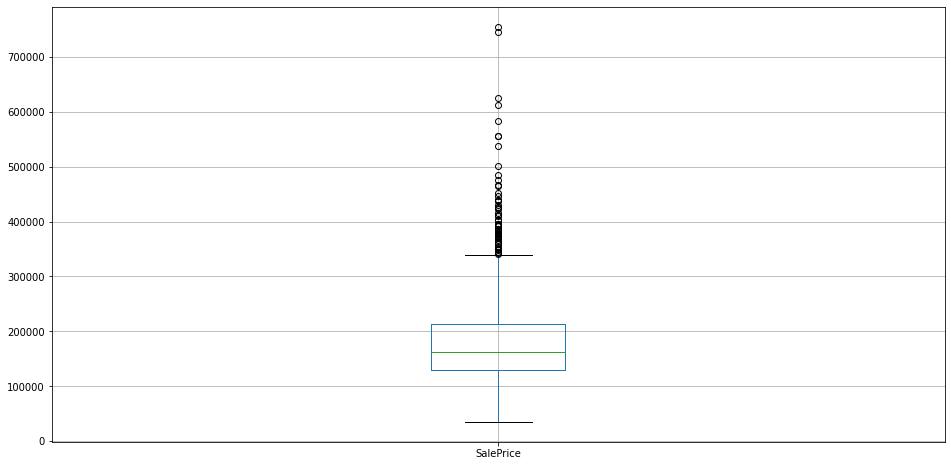

In [ ]:
numerical_df.boxplot("SalePrice",figsize=(16,8))

### Fonction permettant de détercter et nettoyer les outliers dans une colonne donnée

Nous allons utiliser la méthode de l'écart intertquartile 

In [ ]:
#@interact(df_arg=fixed(numerical_df),k=(3,0,-0.5))
def remove_outliers_iqr(df_arg,k = 1.5):
    df_iqr = df_arg.copy()
    #columns = [col for col in df_arg.columns]
    for col in df_arg.columns:
        q25, q75 = q25, q75 = df_iqr[col].quantile(.25), df_iqr[col].quantile(.75)
        ecart_iqr = q75- q25
        cut_off = ecart_iqr*k
        lower = q25-cut_off
        upper = q75+cut_off
        df_iqr[col] =np.where(((df_iqr[col]< lower)|(df_iqr[col]> upper)),np.nan,df_iqr[col])
    return df_iqr  

In [ ]:
k1 = 3
k2 = 2.5
k3 = 2
df_res = remove_outliers_iqr(numerical_df, k1)
df_res2 = remove_outliers_iqr(numerical_df, k2)
df_res3 = remove_outliers_iqr(numerical_df,k3)

In [ ]:
numerical_df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,991.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,1298.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
df_res.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1426.000000,1460.000000,1459.000000,1460.000000,1460.000000,1459.000000,1293.0,1460.000000,1455.000000,...,1457.000000,1442.000000,1252.0,1436.0,1344.0,1453.0,1408.0,1460.000000,1460.000000,1448.000000
mean,56.897260,9519.417251,6.099315,5.578478,1971.267808,1984.865753,440.075394,0.0,567.240411,1048.178007,...,92.845573,42.841193,0.0,0.0,0.0,0.0,0.0,6.321918,2007.815753,177657.070442
std,42.300571,3596.832805,1.382997,1.106709,30.202904,20.645407,435.438756,0.0,441.866955,404.127796,...,121.580916,56.277447,0.0,0.0,0.0,0.0,0.0,2.703626,1.328095,70678.078392
min,20.000000,1300.000000,1.000000,2.000000,1872.000000,1950.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,2006.000000,34900.000000
25%,20.000000,7500.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.0,223.000000,795.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.000000,2007.000000,129900.000000
50%,50.000000,9369.500000,6.000000,5.000000,1973.000000,1994.000000,383.000000,0.0,477.500000,990.000000,...,0.000000,24.000000,0.0,0.0,0.0,0.0,0.0,6.000000,2008.000000,162000.000000
75%,70.000000,11365.750000,7.000000,6.000000,2000.000000,2004.000000,712.000000,0.0,808.000000,1292.000000,...,168.000000,66.000000,0.0,0.0,0.0,0.0,0.0,8.000000,2009.000000,212925.000000
max,190.000000,23595.000000,10.000000,9.000000,2010.000000,2010.000000,2260.000000,0.0,2336.000000,2633.000000,...,670.000000,267.000000,0.0,0.0,0.0,0.0,0.0,12.000000,2010.000000,465000.000000


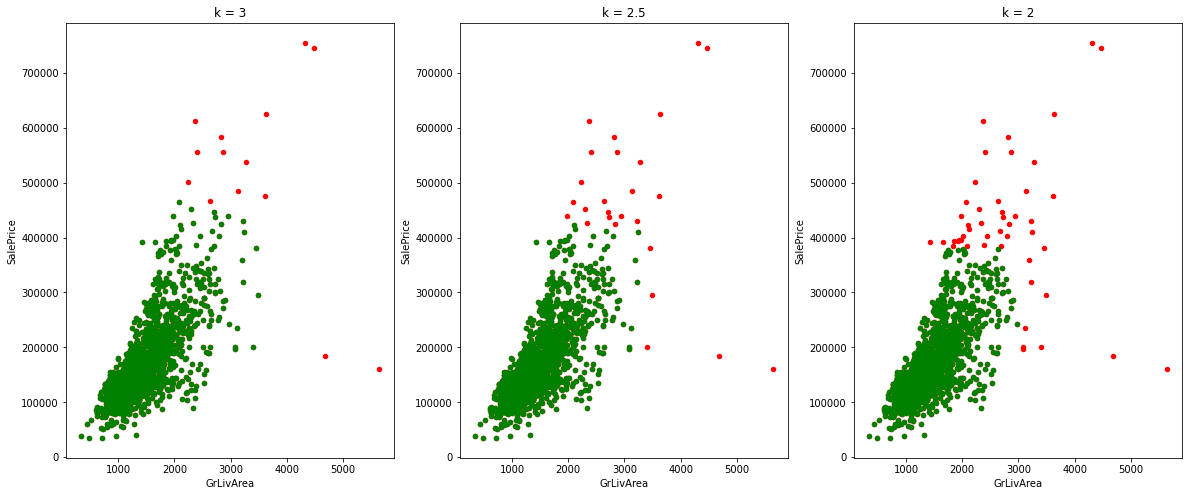

In [ ]:
def plot_view(x_col,numerical_df = numerical_df,target = "SalePrice"):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize  =(20,8))
    numerical_df.plot.scatter(x=x_col, y = target, ax = ax1, color ="red")
    df_res.plot.scatter(x=x_col, y = target, ax = ax1, color = "green")
    numerical_df.plot.scatter(x=x_col, y = target, ax = ax2, color ="red")
    df_res2.plot.scatter(x=x_col, y = target, ax = ax2, color = "green")
    numerical_df.plot.scatter(x=x_col, y = target, ax = ax3, color ="red")
    df_res3.plot.scatter(x=x_col, y = target, ax = ax3, color = "green")
    ax1.set_title(f'k = {k1}')
    ax2.set_title(f'k = {k2}')
    ax3.set_title(f'k = {k3}')

plot_view("GrLivArea")

    

### On constate que pour une valeur de K=0.5, on arrive a déecter et enlever toutes les valeurs aberrantes selon cette méthode d'écart interquartile

## Feature Selection

### Correaltion entre différentes variables numériques

In [ ]:
correlation_num =numerical_df.corr()

In [ ]:
correlation_num.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,-0.238518,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,0.260833,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,0.537808,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.046231,0.040229,-0.136841,-0.171098,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,0.391452,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897


### heatmap de la matrice de corrélation (r>.5)

<AxesSubplot:title={'center':'Correlation'}>

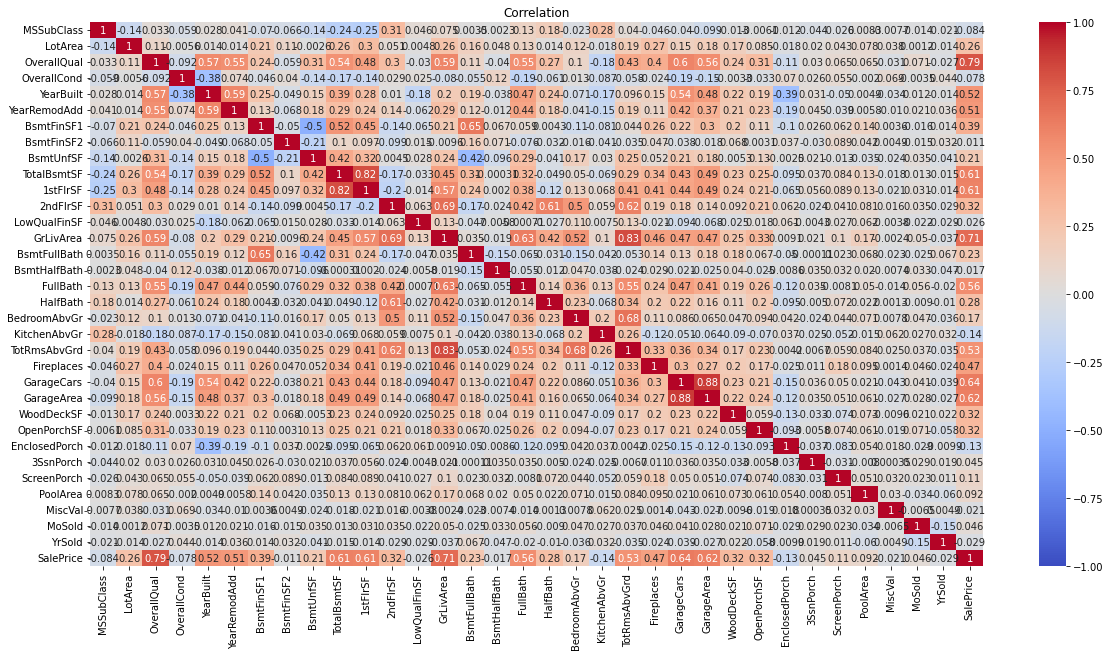

In [ ]:
plt.figure(figsize= (20,10))
plt.title('Correlation')
sns.heatmap(correlation_num,vmin = -1, cmap = "coolwarm",vmax = 1, annot = True)

### Focus sur la correlation entre la target et les autres features

In [ ]:
def corr_feature_selector(threshold, target = "SalePrice",corr = correlation_num):
    target_corr= corr[corr[target].abs()>=threshold][target]
    return target_corr, target_corr.axes[0].to_list()


In [ ]:
target_corr, corr_feat_list =corr_feature_selector(.5)
corr_feat_list

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice']

### Heatmap de la corrélation entre ces 11 variables 

<AxesSubplot:title={'center':'Correlation'}>

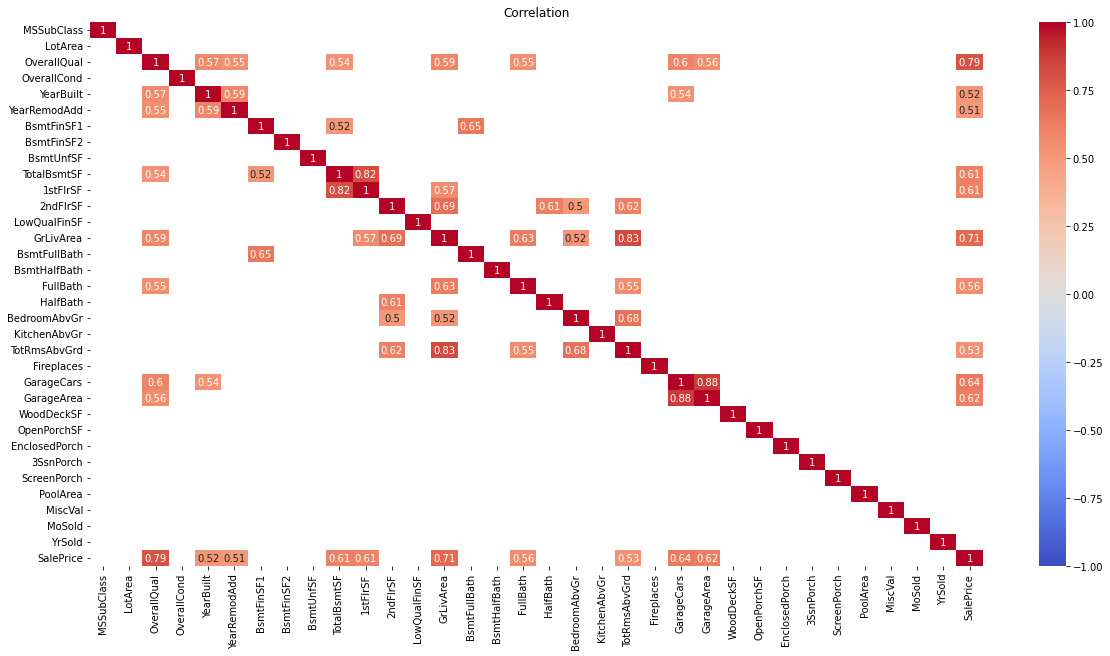

In [ ]:
plt.figure(figsize= (20,10))
plt.title('Correlation')
sns.heatmap(correlation_num[correlation_num.abs()>.5],vmin = -1,cmap = "coolwarm",vmax = 1, annot = True, robust=True)

In [ ]:
target_corr.nlargest(7)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64

### Liste des variables numériques ayant une corrélation supéireure ou égale à 0.5:
- OverallQual
- YearBuilt
- YearRemodAdd
- TotalBsmtSF
- 1stFlrSF 
- GrLivArea
- FullBath
- TotRmsAbvGrd
- GarageCars
- GarageArea


### Barplot des variables numérriques ayant une corrélation supérieure à 0.5 avec la target 

<AxesSubplot:>

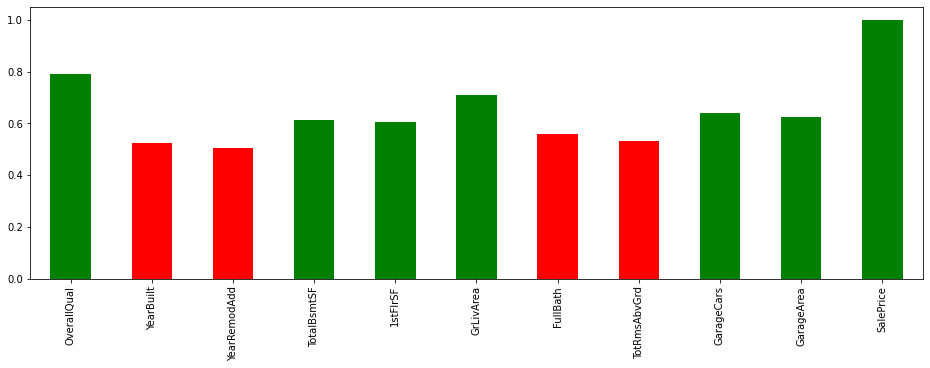

In [ ]:
target_corr.plot.bar(figsize =(16,5), color=np.where(target_corr.values>.6,"green","red"))

### Toutes ces 10 variables évoluent dans le même sens que le SalePrice car corrélation positive

### Focus sur le sous-ensemble de données 11 variables 

In [ ]:
top_11_numerical_df = numerical_df[corr_feat_list]

In [ ]:
top_11_numerical_df.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,7,2003,2003,856,856,1710,2,8,2,548,208500
1,6,1976,1976,1262,1262,1262,2,6,2,460,181500
2,7,2001,2002,920,920,1786,2,6,2,608,223500
3,7,1915,1970,756,961,1717,1,7,3,642,140000
4,8,2000,2000,1145,1145,2198,2,9,3,836,250000


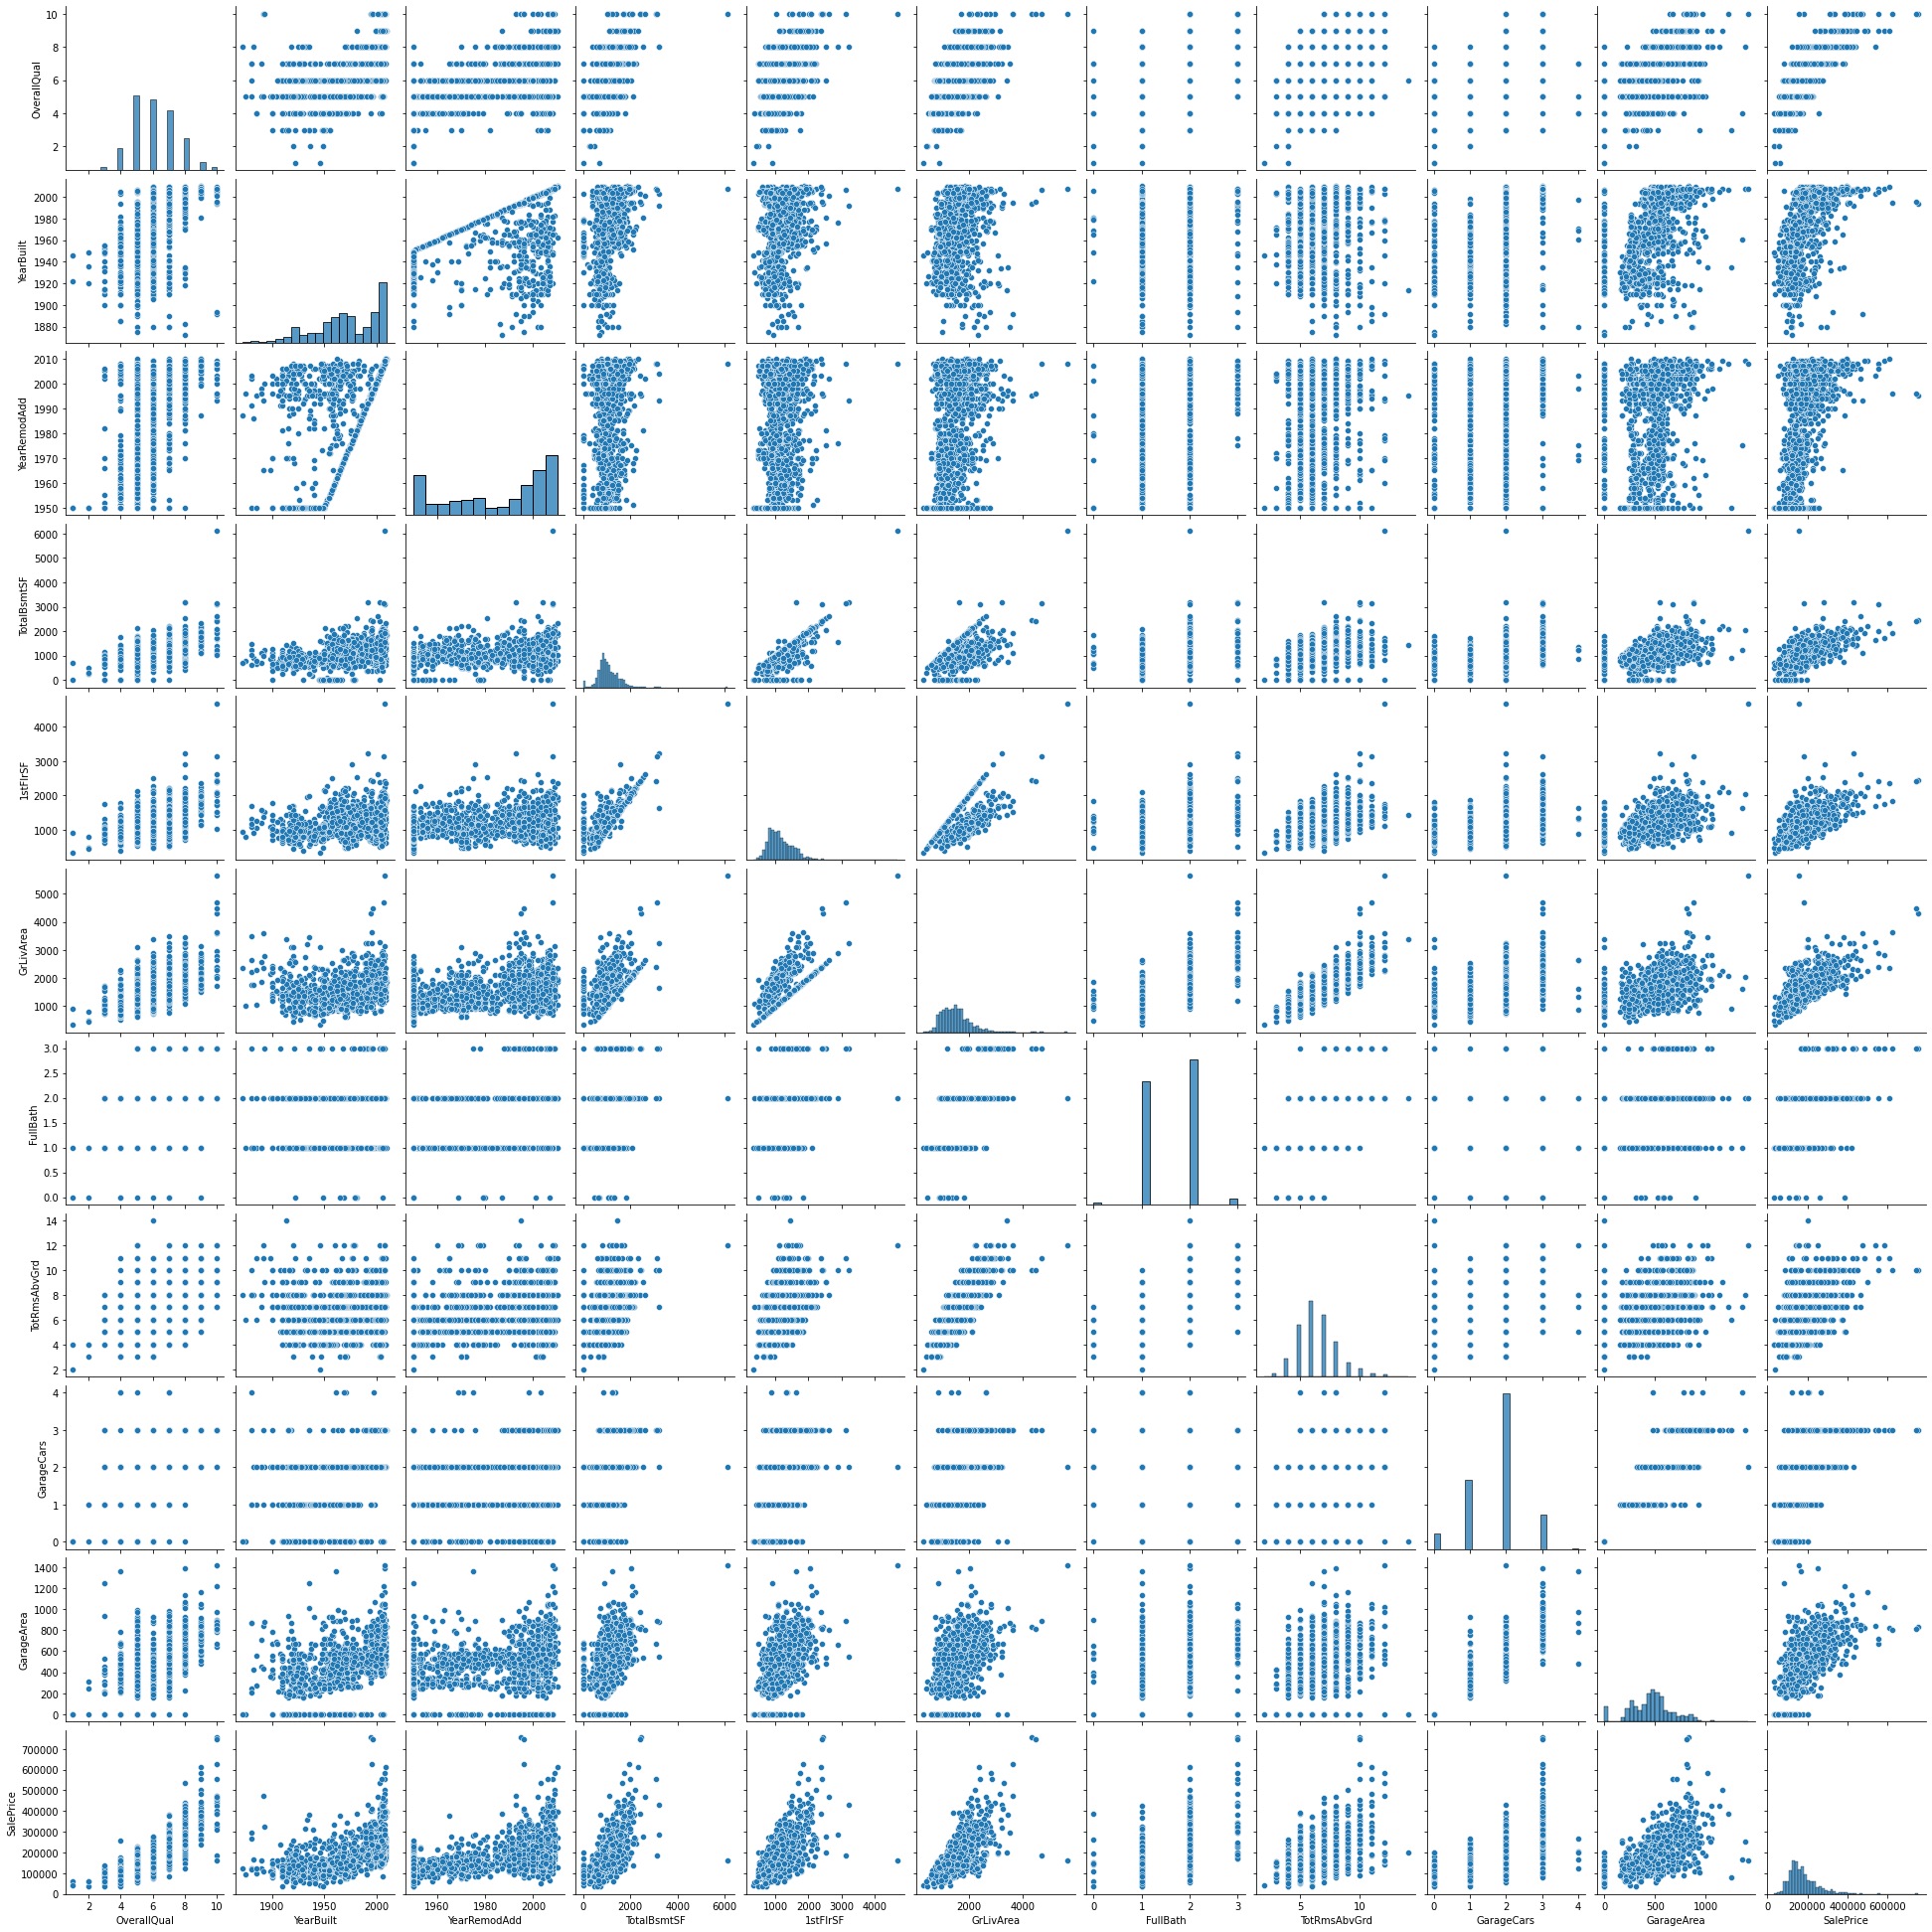

In [ ]:
sns.pairplot(top_11_numerical_df)

In [ ]:
#!pip install -U scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\DANSO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### RandomForest regrssor

In [ ]:
def rf_features_selector(df_arg,top_n,target_name ="SalePrice"):
    seed = np.random.seed(10)
    #df_w = df_arg.copy()
    features = [col for col in df_arg.columns if col!=target_name]
    X = df_arg.copy()[features]
    y = df_arg[target_name].values
    model = RandomForestRegressor(random_state = seed)
    model.fit(X,y)
    #get feaures importance
    importance = model.feature_importances_
    indices = np.argsort(importance)
    feat_importances = pd.Series(importance, index=X.columns)
    plot = feat_importances.nlargest(top_n).plot(kind='barh', figsize =(10,5))
    plt.xlabel('importance')
    rf_features = pd.DataFrame(feat_importances.nlargest(top_n)).axes[0].tolist()
    return plot, rf_features

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 '1stFlrSF',
 'LotArea',
 'GarageCars',
 'GarageArea',
 'YearBuilt',
 'YearRemodAdd',
 'FullBath',
 'TotRmsAbvGrd',
 'WoodDeckSF',
 'OverallCond']

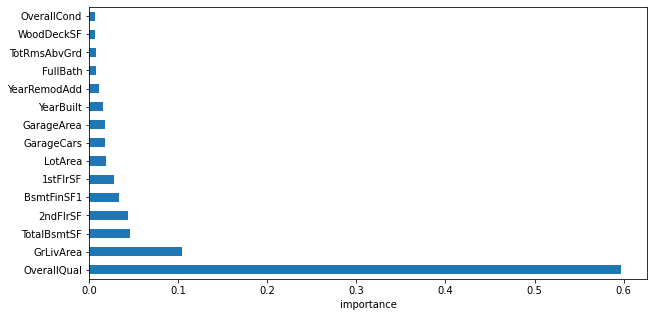

In [ ]:
plot, rf_feat_list = rf_features_selector(numerical_df,15)
rf_feat_list

### LasssoRegression

In [ ]:
def lassoReg_feat_selector(df_arg=numerical_df,target_name ="SalePrice"):
    np.random.seed(10)
    features = [col for col in df_arg.columns if col!=target_name]
    X = df_arg.copy()[features]
    y = df_arg[target_name].values
    estimator = LassoCV(cv=5)
    sfm = SelectFromModel(estimator, prefit=False, norm_order=1, max_features=None)
    sfm.fit(X,y)
    feature_idx = sfm.get_support()
    Lasso_features = X.columns[feature_idx].tolist()
    return Lasso_features

In [ ]:
lasso_feat_list = lassoReg_feat_selector()
lasso_feat_list

['LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'MiscVal']

### Recursive feature selection

In [ ]:
def rfe_feature_selector(df_arg= numerical_df,target_name ="SalePrice"):
    np.random.seed(10)
    features = [col for col in df_arg.columns if col!=target_name]
    X = df_arg.copy()[features]
    y = df_arg[target_name].values
    rfe= RFE(estimator=LinearRegression(),n_features_to_select=15)
    rfe.fit(X,y)
    rfe_support = rfe.get_support()
    rfe_feat = X.loc[:,rfe_support].columns.to_list()
    return rfe_feat
    

In [ ]:
rfe_feat_list = rfe_feature_selector()
rfe_feat_list


['OverallQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'GarageCars']

### Mutual information feature selection

In [ ]:
def mif_feature_selector(df_arg= numerical_df,target_name ="SalePrice"):
    np.random.seed(10)
    features = [col for col in df_arg.columns if col!=target_name]
    X = df_arg.copy()[features]
    y = df_arg[target_name].values
    mif= SelectKBest(score_func=mutual_info_regression,k =15)
    mif.fit(X, y)
    mif_support = mif.get_support()
    mif_feat = X.loc[:,mif_support].columns.to_list()
    return mif_feat
    
    
    

In [ ]:
mif_feat_list = mif_feature_selector()
mif_feat_list

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea']

## Combinaison des features selectionnées par différentes méthodes 

In [ ]:
from collections import Counter
combined_feat_list  =rfe_feat_list+lasso_feat_list+rfe_feat_list+corr_feat_list+mif_feat_list
feat_freq= Counter(combined_feat_list)
feat_freq_df = pd.DataFrame({"Feature":feat_freq.keys(),"Frequence":feat_freq.values()})
feat_freq_df.sort_values("Frequence", ascending =False)
feat_freq_df = feat_freq_df[feat_freq_df.Feature!="SalePrice"]

In [ ]:
feat_freq_df

NameError: name 'feat_freq_df' is not defined

<AxesSubplot:xlabel='Feature'>

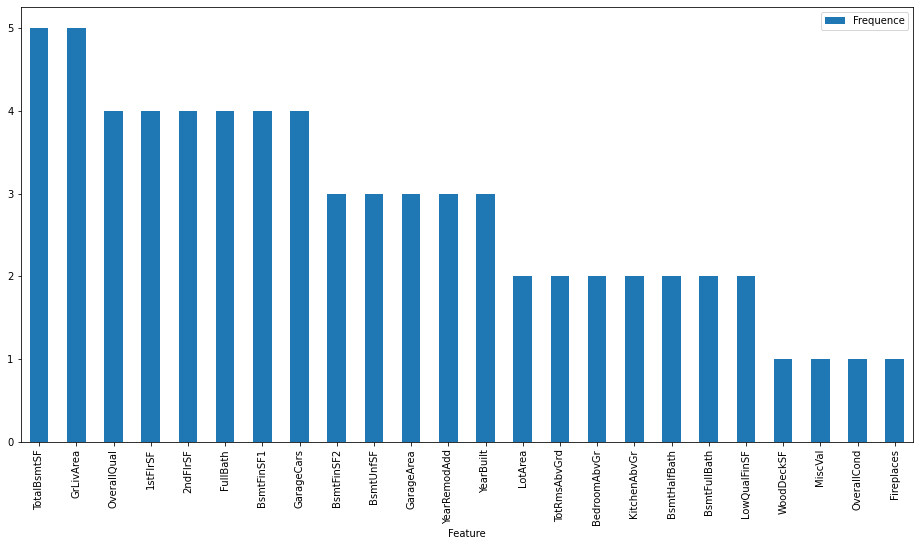

In [ ]:
feat_freq_df.sort_values("Frequence", ascending=False).plot.bar("Feature", figsize = (16,8))

In [ ]:
selected_features = feat_freq_df[feat_freq_df.Frequence>0].Feature.values
selected_features

array(['OverallQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'GarageCars', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'GarageArea', 'WoodDeckSF', 'MiscVal',
       'TotRmsAbvGrd', 'OverallCond', 'Fireplaces'], dtype=object)

In [ ]:
len(selected_features)

24

### Suppression des colonnes
- BsmtFinSF2
- BsmtFinSF1 et 
- BsmtUnSF 

Car elles sont toutes combinées dans la colonne **TotalBsmtSF**

In [ ]:
final_df = numerical_df[selected_features]
final_features = final_df.drop(columns=["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","LowQualFinSF","BsmtFullBath","BsmtHalfBath"]).columns

### Visualisation des résultats de nettoyage

C:\Users\DANSO\AppData\Local\Temp/ipykernel_6124/1675850555.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize  =(20,8))


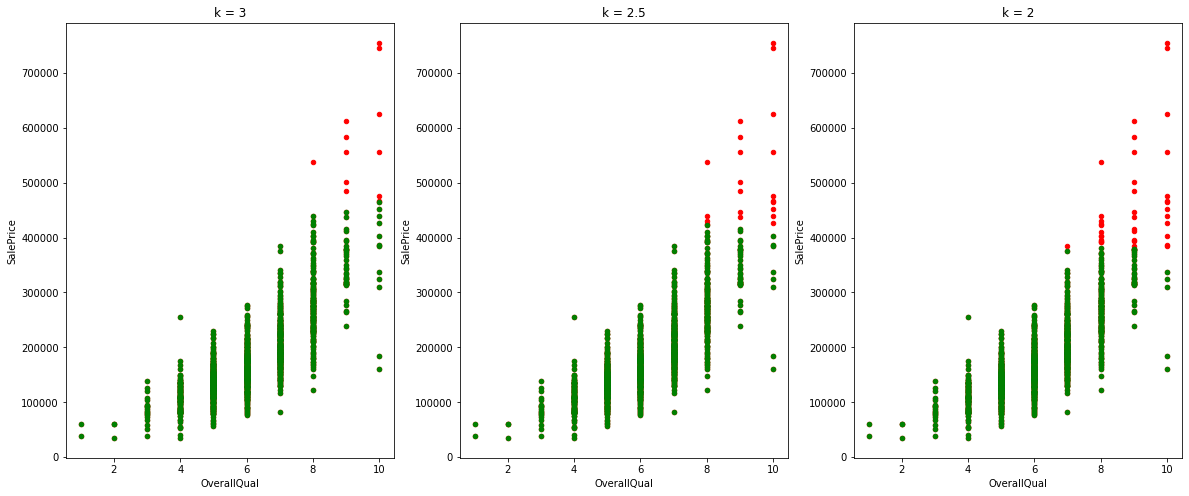

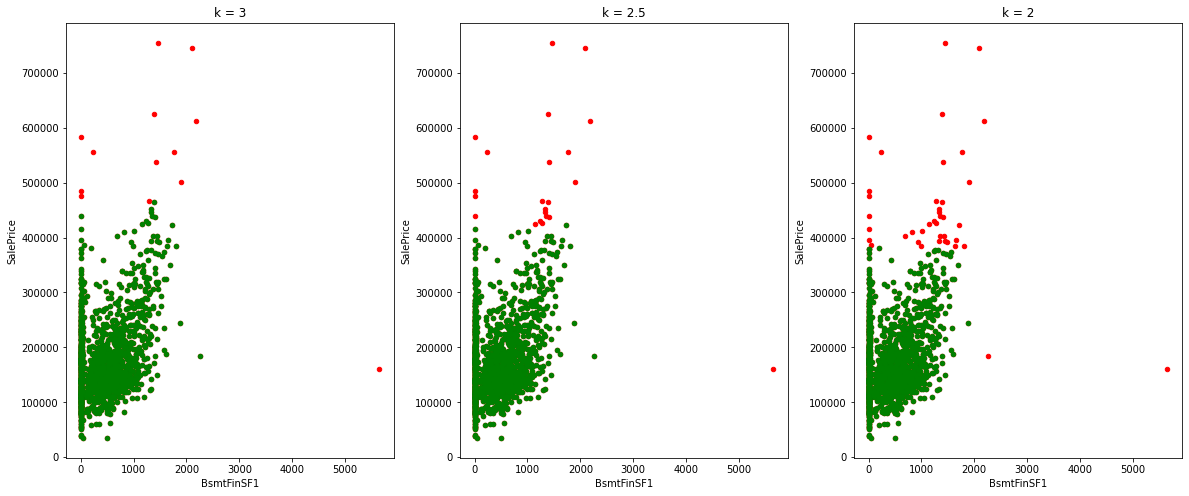

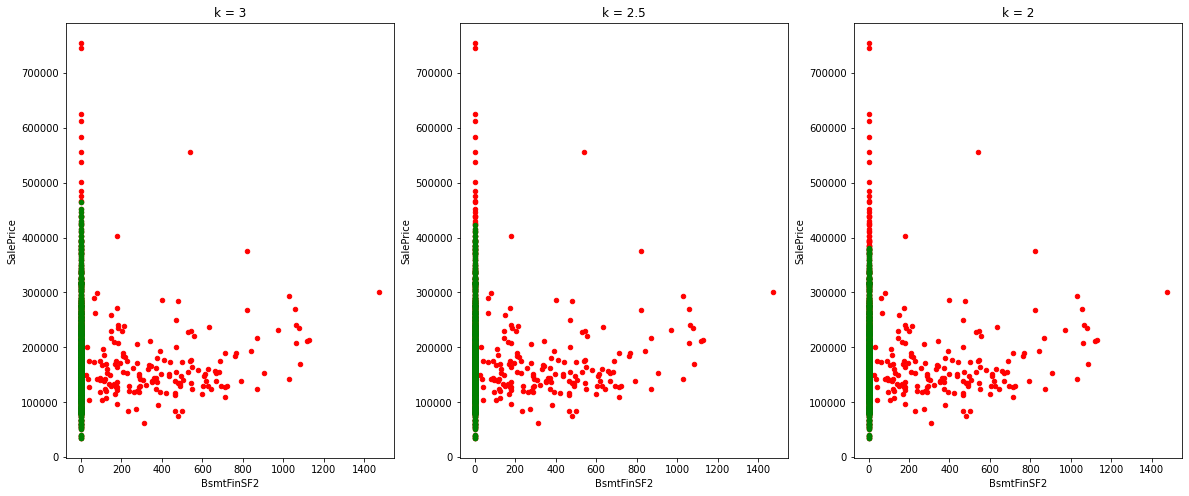

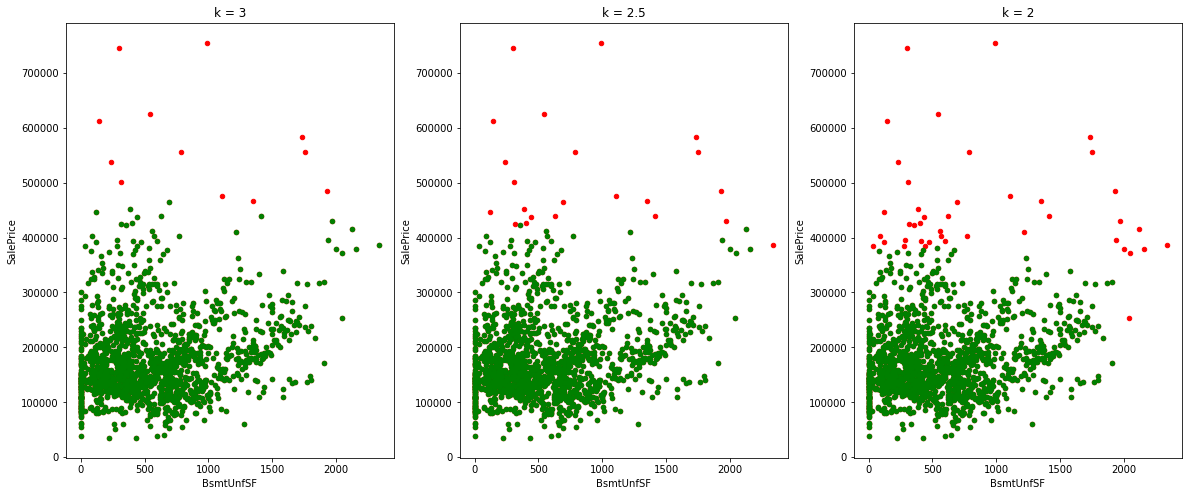

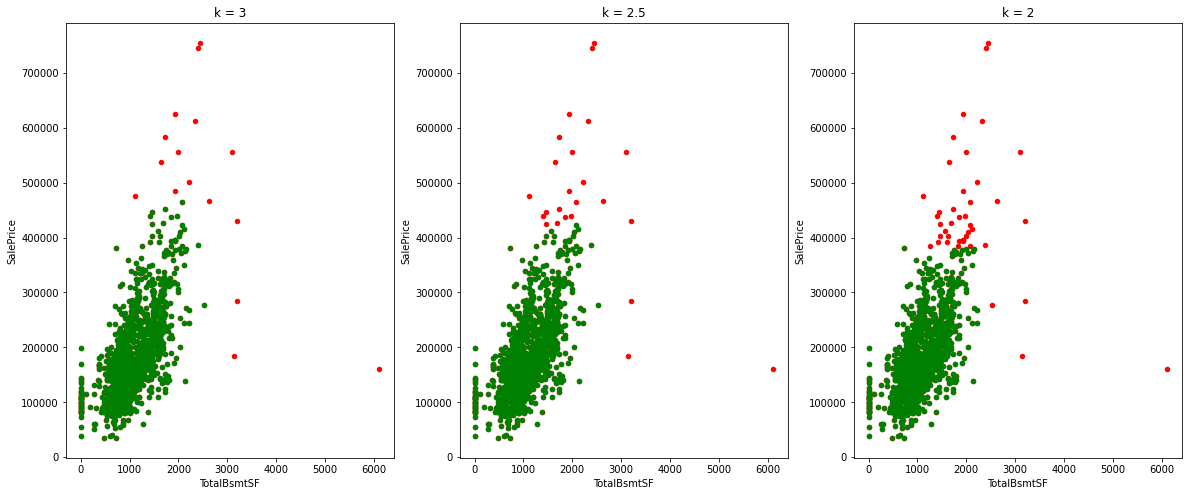

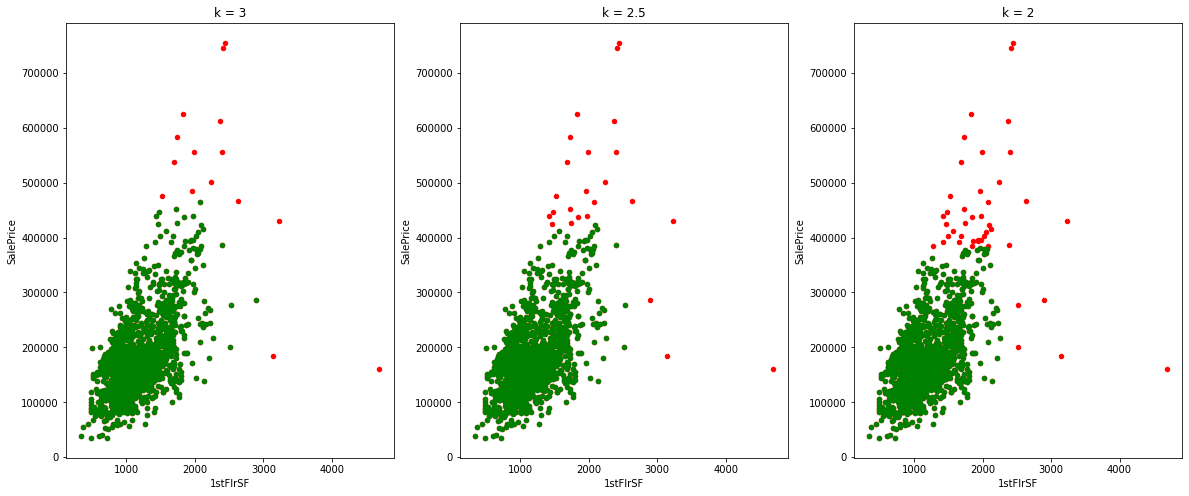

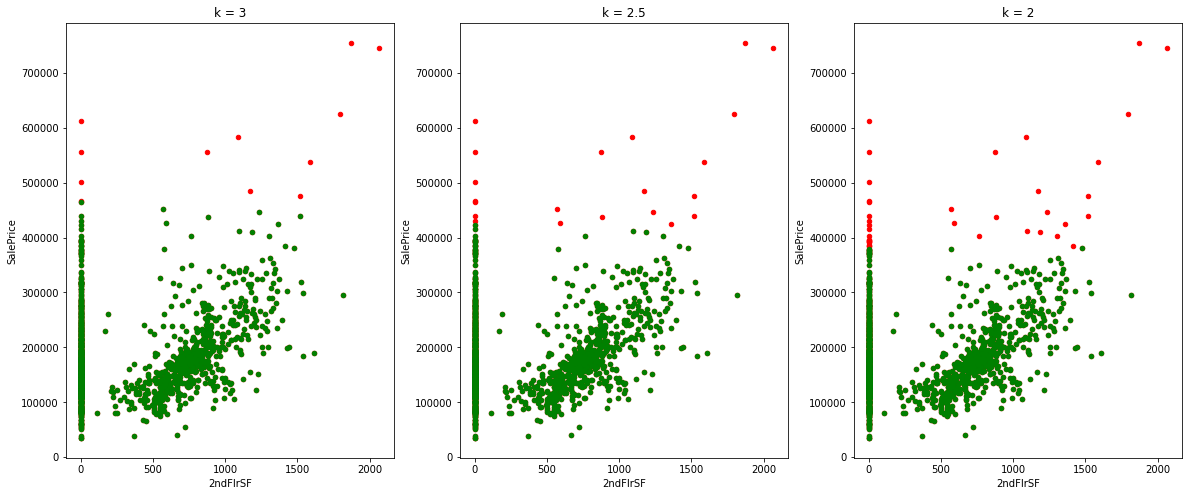

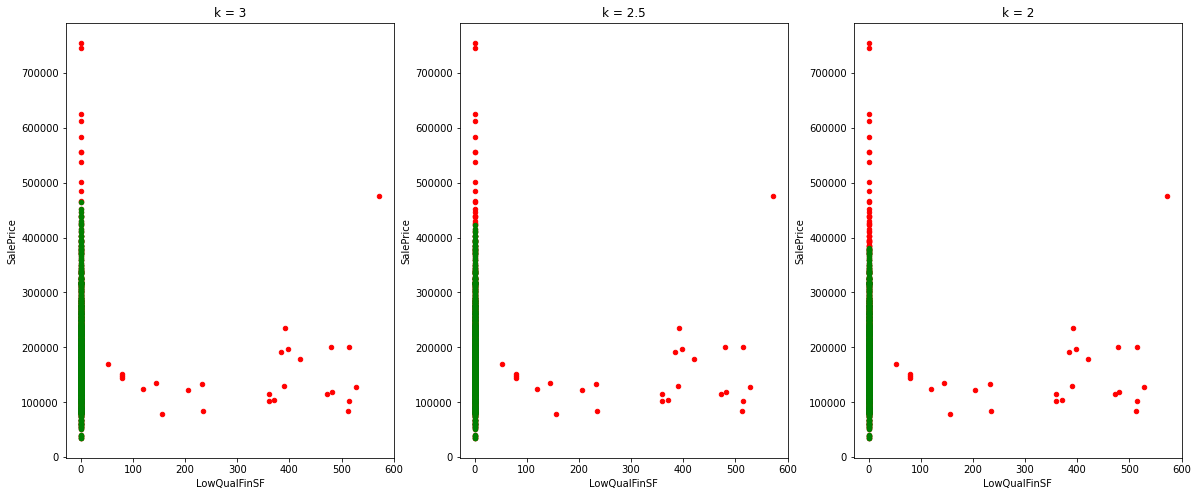

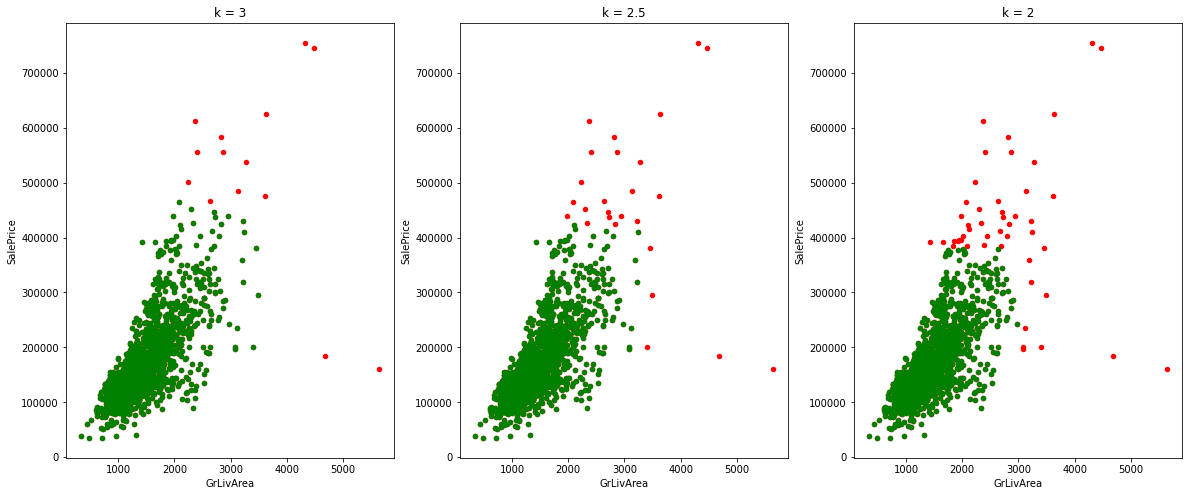

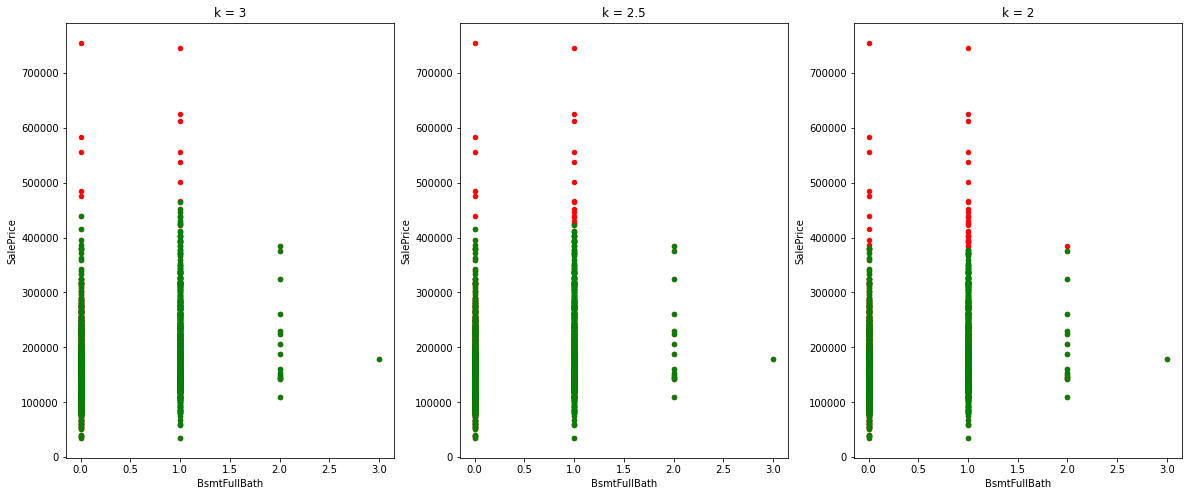

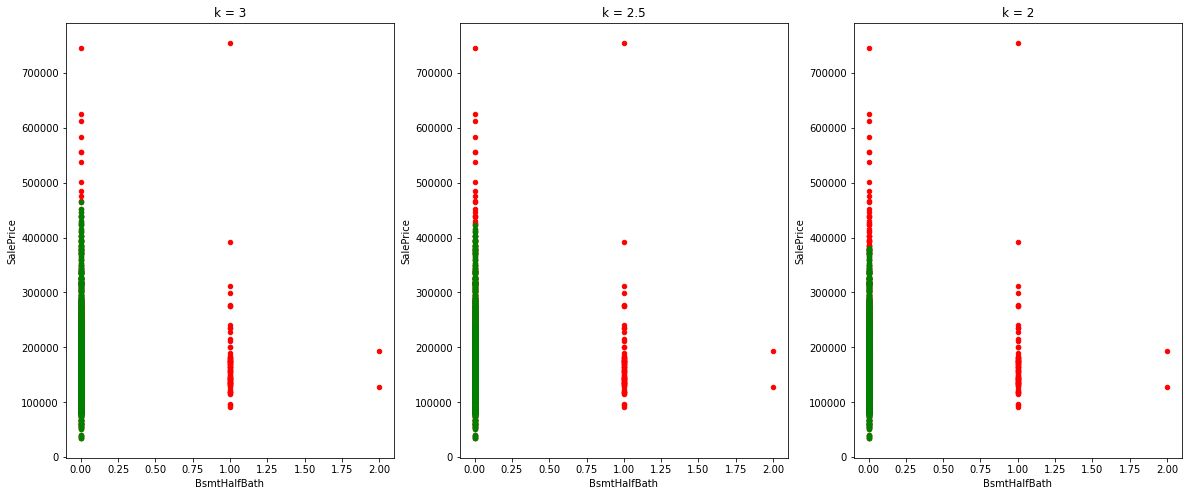

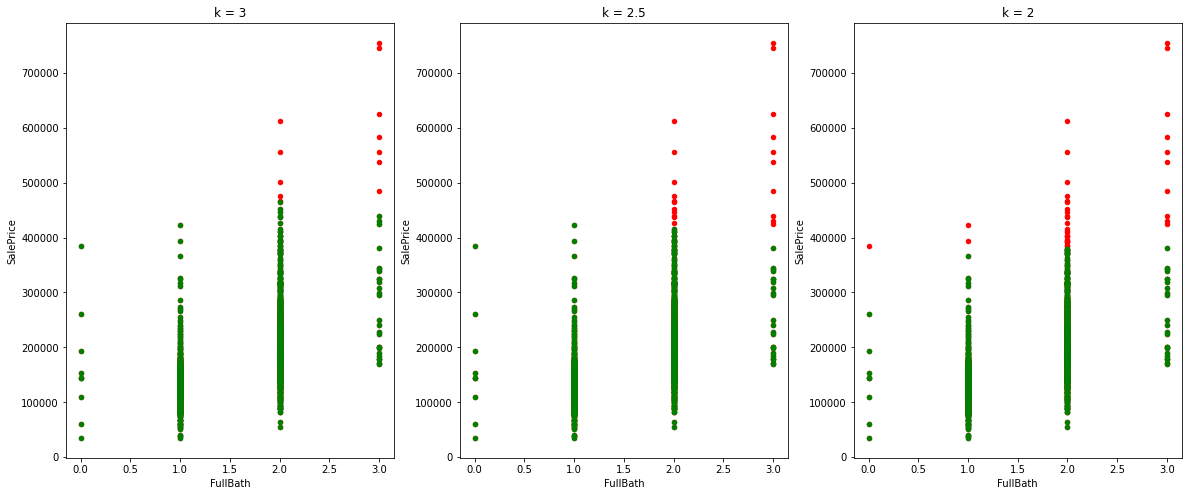

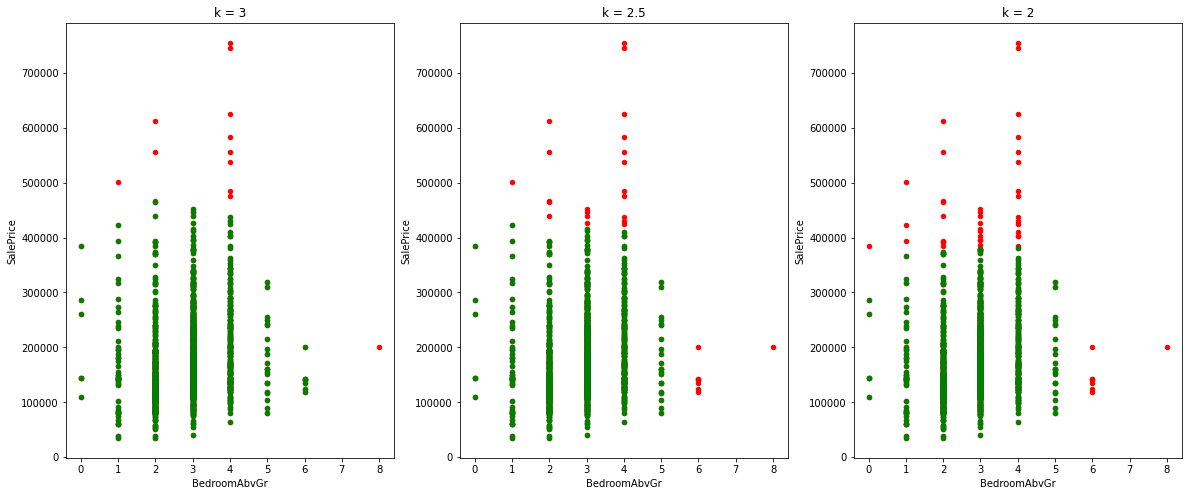

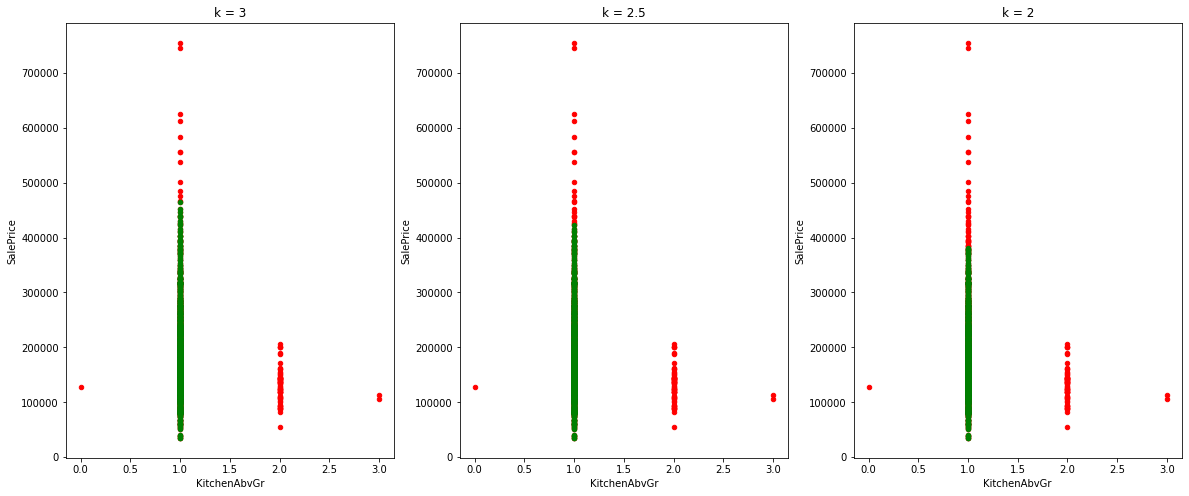

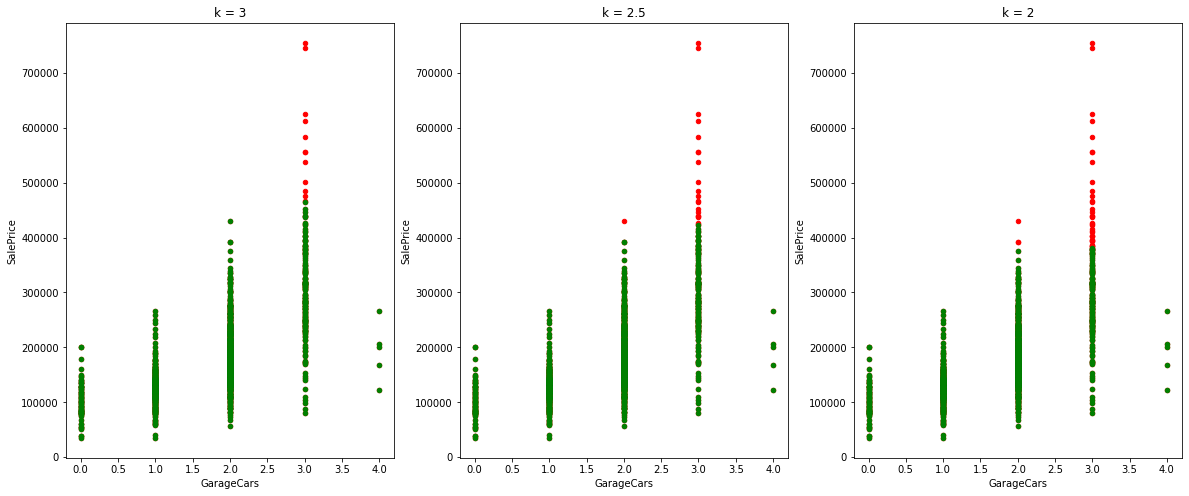

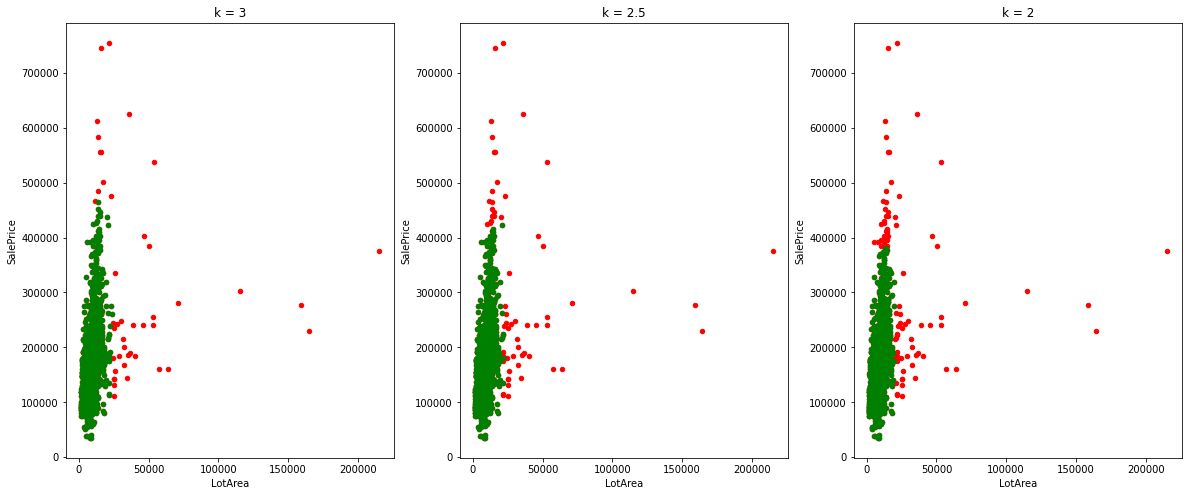

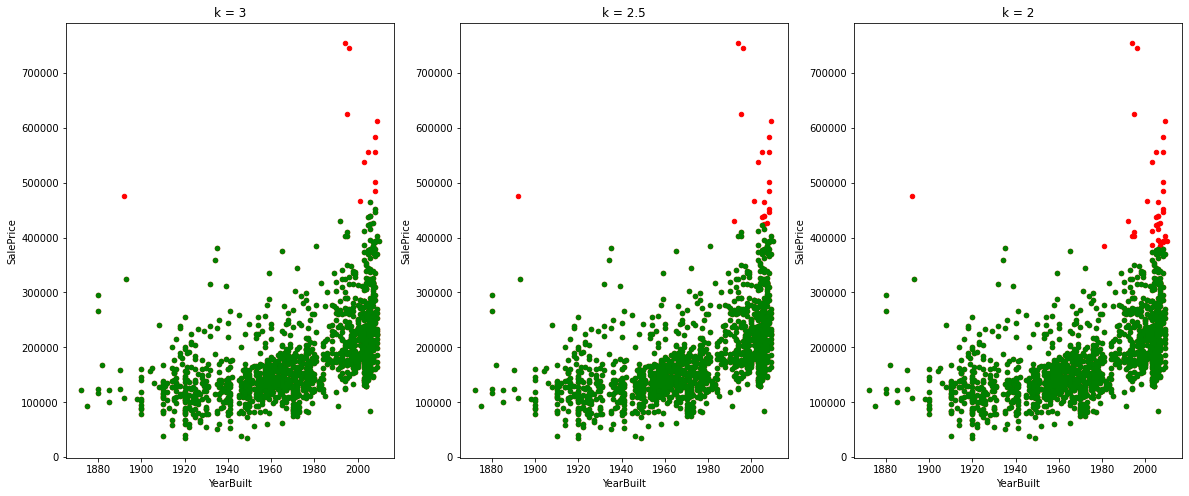

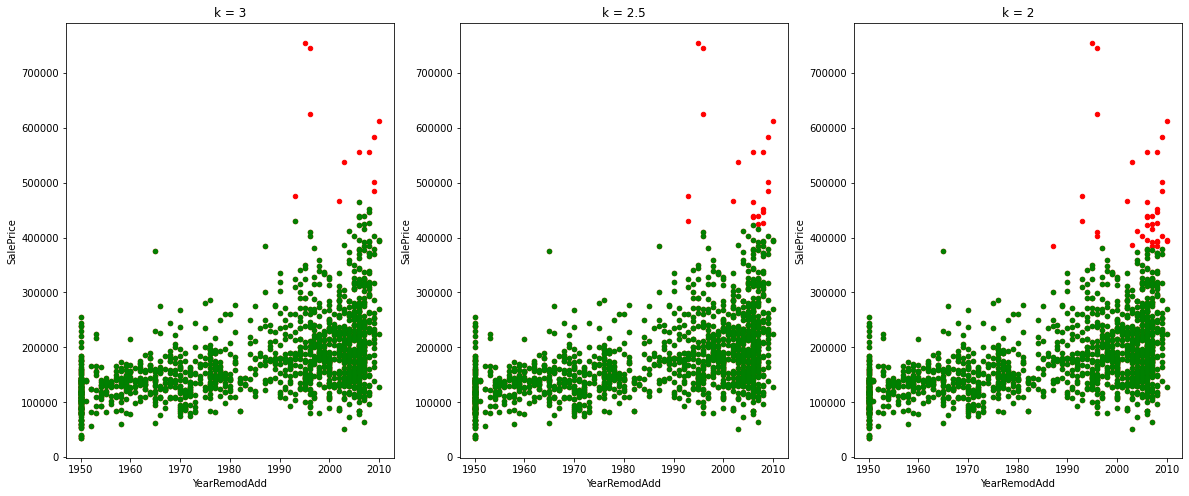

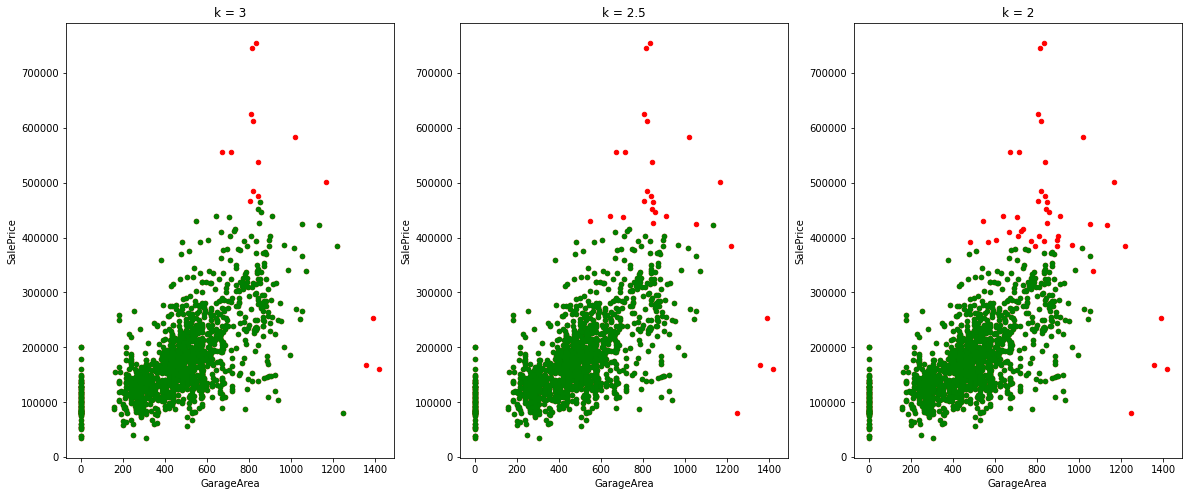

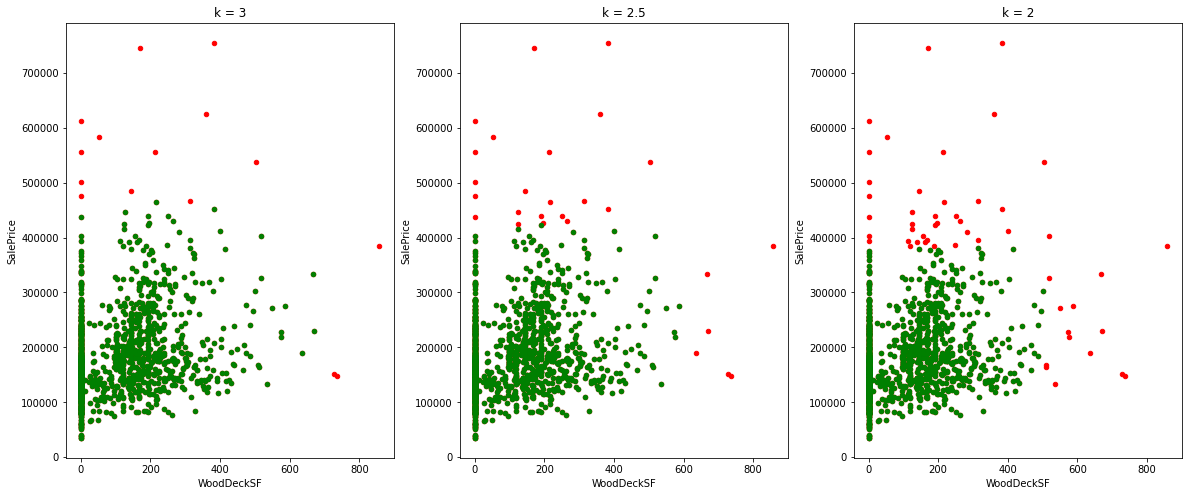

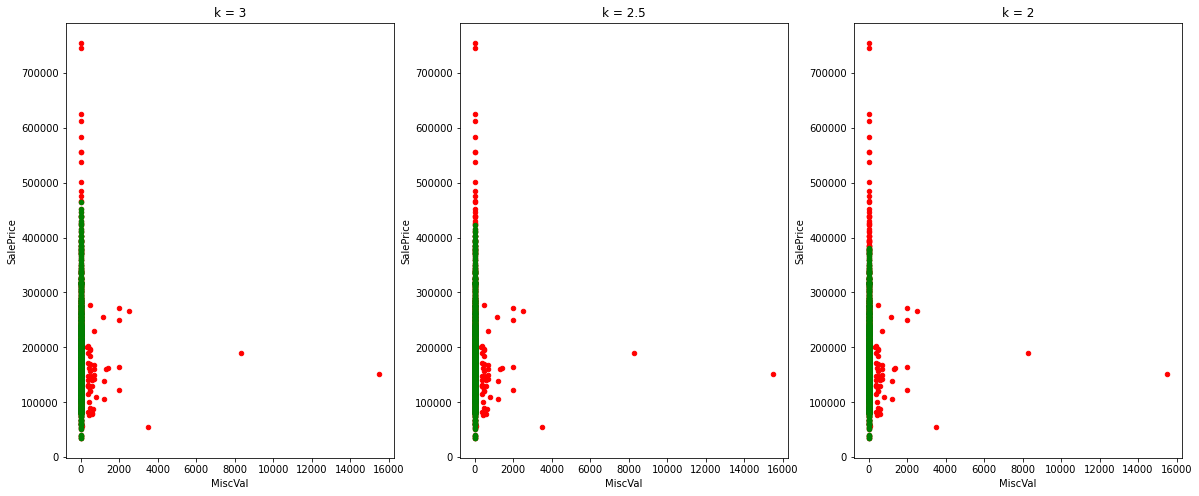

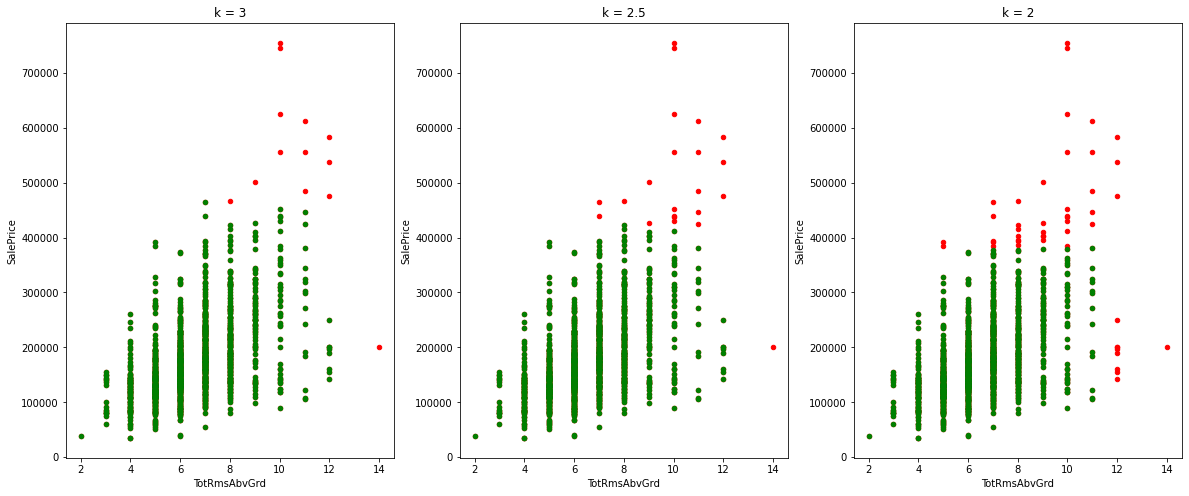

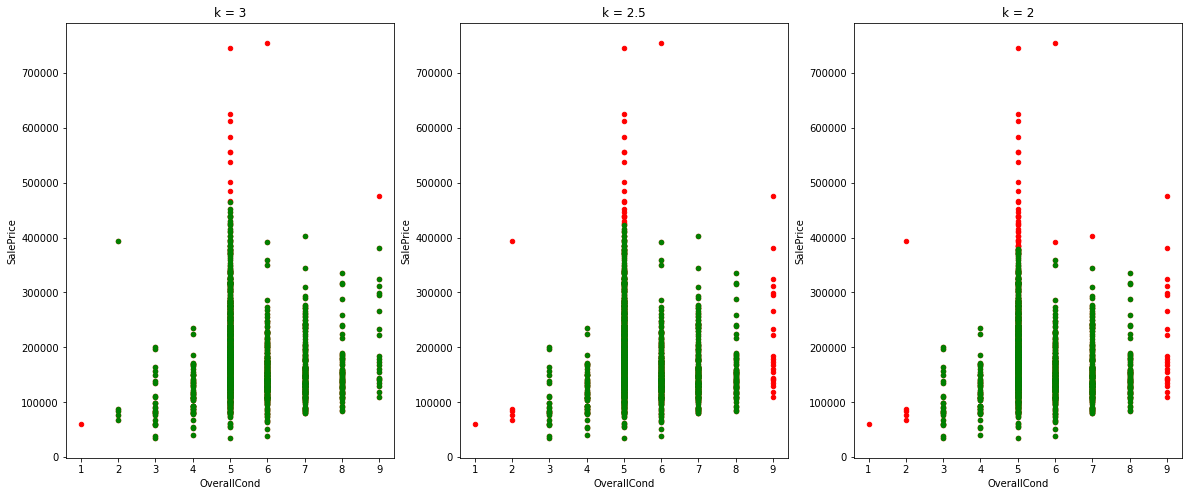

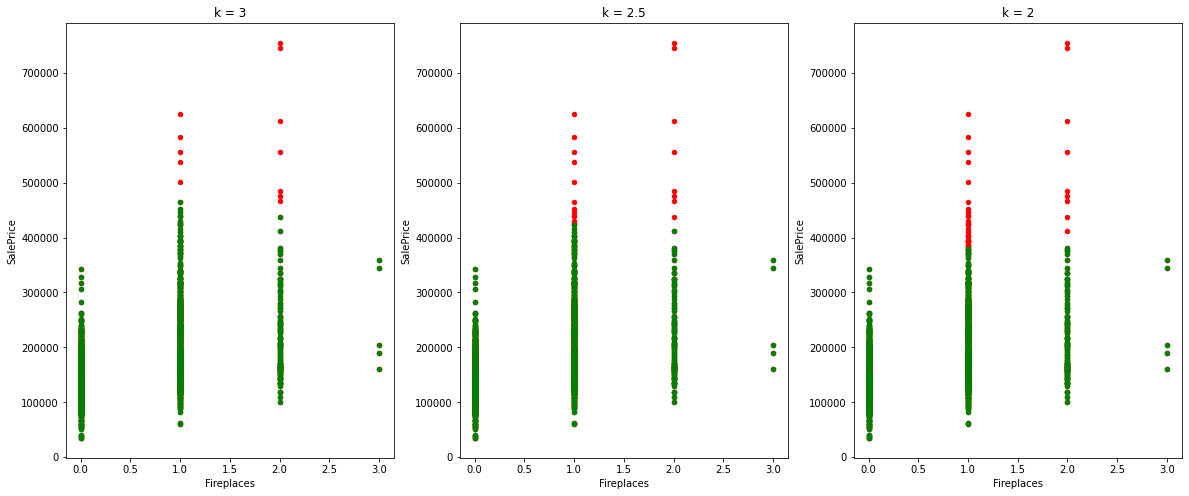

In [ ]:
for col in final_df.columns:
    plot_view(col)

#### Installation du package lazypredict 

In [ ]:
%pip install lazypredict

# Prediction avec les modéles classique 

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
def lazy_predict(features,df_arg,target_name="SalePrice", k= 2.5):
    df_cleaned =remove_outliers_iqr(df_arg.copy(),k)
    df_cleaned = df_cleaned.dropna(axis=0)
    if target_name in features:
        features.remove(target_name)
    X = df_cleaned[features].values
    y = df_cleaned.SalePrice.values
    x_slc = MinMaxScaler()
    y_scl = MinMaxScaler()
    X_scaled = x_slc.fit_transform(X)
    y_scaled=y_scl.fit_transform(y.reshape(-1,1))
    trainX,testX,trainY,testY = train_test_split(X_scaled,y_scaled,train_size =0.7)
    reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = reg.fit(trainX,testX, trainY,testY)
    return models, predictions
    

In [ ]:
experiment_selected_features = feat_freq_df[feat_freq_df.Frequence>1].Feature.values
experiment_selected_features

array(['OverallQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'GarageCars', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'GarageArea', 'TotRmsAbvGrd'], dtype=object)

In [ ]:
models,predictions = lazy_predict(experiment_selected_features,numerical_df,3)
print(models) 

100%|██████████| 42/42 [00:21<00:00,  1.98it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.91       0.92  0.05        0.44
LGBMRegressor                                0.91       0.92  0.05        0.20
NuSVR                                        0.91       0.92  0.05        0.17
HistGradientBoostingRegressor                0.90       0.91  0.05        0.79
ExtraTreesRegressor                          0.90       0.91  0.05        0.52
RandomForestRegressor                        0.90       0.91  0.06        1.40
LinearSVR                                    0.90       0.90  0.06        0.05
RidgeCV                                      0.90       0.90  0.06        0.03
XGBRegressor                                 0.90       0.90  0.06        0.38
BayesianRidge                                0.90       0.90  0.06        0.02
Ridge                                        0.90   

<AxesSubplot:xlabel='Model'>

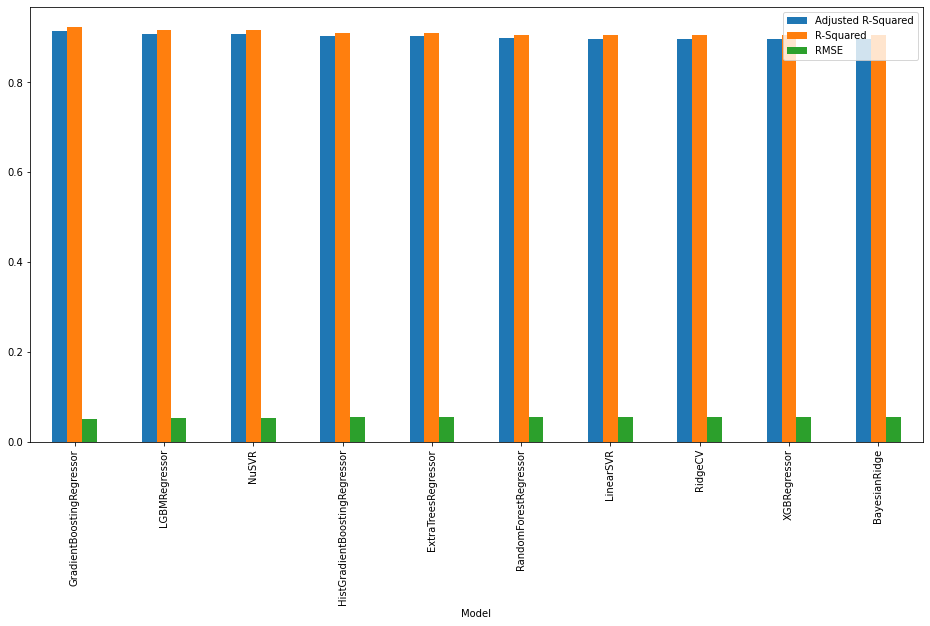

In [ ]:
models[models>=0][["Adjusted R-Squared","R-Squared","RMSE"]].nlargest(10,["Adjusted R-Squared","R-Squared","RMSE"]).plot.bar(figsize  =(16,8))